# Thercy - Optimization Examples

In [1]:
import CoolProp.CoolProp as CP
import numpy as np
import warnings

from CoolProp.Plots import PropertyPlot
from scipy.optimize import differential_evolution, NonlinearConstraint
from thercy.cycles import CycleBuilder

warnings.filterwarnings('ignore')

![Shapiro - Example 8.6](../assets/shapiro-8_6.png)

In [2]:
def build_cycle(x, pmax):
    builder = (CycleBuilder('Water')
    .add_turbine(
        'turbine 1 (1st stage)',
        'steam generator (1st stage)',
        ['closed heater', 'turbine 2 (1st stage)'],
        x[0],
        eta=1.0)
    .add_turbine(
        'turbine 2 (1st stage)',
        'turbine 1 (1st stage)',
        'steam (2nd stage)',
        x[1],
        eta=1.0)
    .add_steam_generator(
        'steam (2nd stage)',
        'turbine 2 (1st stage)',
        'turbine 1 (2nd stage)',
        'T',
        440.0 + 273.15)
    .add_turbine(
        'turbine 1 (2nd stage)',
        'steam (2nd stage)',
        ['open heater', 'turbine 2 (2nd stage)'],
        x[2],
        eta=1.0)
    .add_turbine(
        'turbine 2 (2nd stage)',
        'turbine 1 (2nd stage)',
        'condenser',
        x[3],
        eta=1.0)
    .add_condenser(
        'condenser',
        'turbine 2 (2nd stage)',
        'pump (low pressure)')
    .add_pump(
        'pump (low pressure)',
        'condenser',
        'open heater',
        x[2],
        eta=1.0)
    .add_heater_open(
        'open heater',
        ['turbine 1 (2nd stage)', 'pump (low pressure)', 'trap'],
        'pump (high pressure)')
    .add_pump(
        'pump (high pressure)',
        'open heater',
        'closed heater',
        pmax,
        eta=1.0)
    .add_heater_closed(
        'closed heater',
        ['turbine 1 (1st stage)'],
        'pump (high pressure)',
        'trap',
        'steam generator (1st stage)',
        x[4] + 273.15)
    .add_trap(
        'trap',
        'closed heater',
        'open heater',
        x[2])
    .add_steam_generator(
        'steam generator (1st stage)',
        'closed heater',
        'turbine 1 (1st stage)',
        'T',
        480.0 + 273.15)
    )

    return builder.build()


def cost_function(x, pmax, x0):
    cycle = build_cycle(x, pmax)
    sol = cycle.solve(x0, ['P', 'T'], fatol=1e-2)
    return -100.0 * cycle.efficiency

In [3]:
def create_constraint(i):
    return NonlinearConstraint(lambda x: x[i] - x[i + 1], 0.0, np.inf)


def constr_conserv(x, pmax, x0):
    cycle = build_cycle(x, pmax)
    sol = cycle.solve(x0, ['P', 'T'], fatol=1e-2)
    return sol.fun

pressure_max = 8.0e6

x0_opt = np.array([2.0e6, 0.7e6, 0.3e6, 8.0e3, 205.0])
x0 = np.array([
    [pressure_max, 500.0],  # Index:  0, State:  1
    [x0_opt[0], 500.0],     # Index:  1, State:  2
    [x0_opt[0], 500.0],     # Index:  2, State:  2
    [x0_opt[1], 500.0],     # Index:  3, State:  3
    [x0_opt[1], 500.0],     # Index:  4, State:  4
    [x0_opt[2], 500.0],     # Index:  5, State:  5
    [x0_opt[2], 500.0],     # Index:  6, State:  5
    [x0_opt[3], 500.0],     # Index:  7, State:  6
    [x0_opt[3], 500.0],     # Index:  8, State:  7
    [x0_opt[2], 500.0],     # Index:  9, State:  8
    [x0_opt[2], 500.0],     # Index: 10, State: 13
    [pressure_max, 500.0],  # Index: 11, State:  9
    [x0_opt[0], 500.0],     # Index: 12, State: 10 
    [pressure_max, 500.0],  # Index: 13, State: 12
    [x0_opt[2], 500.0],     # Index: 14, State: 11
])

bounds = 4 * [(8.0e3, pressure_max)] + [(100.0, CP.PropsSI('T', 'P', pressure_max, 'Q', 0.0, 'Water') - 273.15)]

# Pressure levels
constraints = [NonlinearConstraint(lambda x: pressure_max - x[0], 0.0, np.inf)]
constraints += [create_constraint(i) for i in range(3)]

# Valid solution
constraints += [NonlinearConstraint(lambda x: constr_conserv(x, pressure_max, x0), 0.0, 1.0)]

res_opt = differential_evolution(
    cost_function,
    bounds=bounds, constraints=constraints, x0=x0_opt, args=(pressure_max, x0,),
    popsize=4, maxiter=1000, workers=-1,
    strategy='best1exp', init='halton',
    polish=False, disp=True
)

print(res_opt)
pressures = res_opt.x

differential_evolution step 1: f(x)= inf
differential_evolution step 2: f(x)= inf
differential_evolution step 3: f(x)= inf
differential_evolution step 4: f(x)= inf
differential_evolution step 5: f(x)= inf
differential_evolution step 6: f(x)= -26.13406301579417
differential_evolution step 7: f(x)= -33.78676990411462
differential_evolution step 8: f(x)= -33.78676990411462
differential_evolution step 9: f(x)= -33.78676990411462
differential_evolution step 10: f(x)= -33.78676990411462
differential_evolution step 11: f(x)= -33.78676990411462
differential_evolution step 12: f(x)= -33.78676990411462
differential_evolution step 13: f(x)= -41.72177906216275
differential_evolution step 14: f(x)= -41.72177906216275
differential_evolution step 15: f(x)= -41.72177906216275
differential_evolution step 16: f(x)= -41.72177906216275
differential_evolution step 17: f(x)= -41.72177906216275
differential_evolution step 18: f(x)= -41.72177906216275
differential_evolution step 19: f(x)= -41.72177906216275
d

In [4]:
cycle = build_cycle(pressures, pressure_max)
sol = cycle.solve(x0, ['P', 'T'])

print(sol.x)
print(f"Residua l: {sol.fun}")
print(f"Iterations: {sol.nit}")
print(f"Efficiency: {cycle.efficiency * 100.0:.1f}%")

# State indexes
# Index:  0, State:  1
# Index:  1, State:  2
# Index:  2, State:  2
# Index:  3, State:  3
# Index:  4, State:  4
# Index:  5, State:  5
# Index:  6, State:  5
# Index:  7, State:  6
# Index:  8, State:  7
# Index:  9, State:  8
# Index: 10, State: 13
# Index: 11, State:  9
# Index: 12, State: 10
# Index: 13, State: 12
# Index: 14, State: 11

State   Temperature (K)     Pressure (Pa)   Density (kg/m3)   Enthalpy (J/kg)  Entropy (J/kg/K)       Quality (-)  Fraction (kg/m3)
    0           753.150       8000000.000            24.776       3349645.166          6661.264            -1.000          1000.000
    1           569.440       2365087.793             9.603       3004667.237          6661.264            -1.000           307.911
    2           569.440       2365087.793             9.603       3004667.237          6661.264            -1.000           692.089
    3           568.135       2341783.900             9.530       3002231.263          6661.264            -1.000           692.089
    4           713.150       2341783.900             7.296       3331524.438          7178.246            -1.000           692.089
    5           523.793        609311.304             2.576       2958576.854          7178.246            -1.000            93.206
    6           523.793        609311.304             2.576       2958576.85

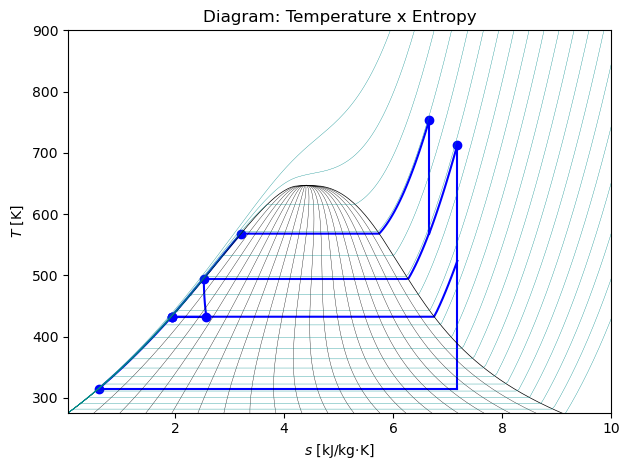

In [5]:
pp = PropertyPlot('Water', 'TS', unit_system='kSI')
pp.calc_isolines(CP.iQ, num=20)
pp.calc_isolines(CP.iP, num=20)

for state in [cloud.to_state_container() for cloud in cycle.graph.cloud_points(100, False)]:
    pp.draw_process(state, line_opts={'color': 'blue', 'lw': 1.5})

pp.title(r'Diagram: Temperature x Entropy')
pp.xlabel(r'$s$ [kJ/kg·K]')
pp.ylabel(r'$T$ [K]')
pp.set_axis_limits([None, 10, None, 900])
pp.show()